# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [3]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Figure 4

## Snapshots of the simulation

In [4]:
!pvpython /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/pv_snapshot_chromatin.py /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/equilibration/24-04-12_aLc1_scan.48_line1600_Pin5um_2xKe30_2patch_sep100/simulations/s1/

!cp /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/equilibration/24-04-12_aLc1_scan.48_line1600_Pin5um_2xKe30_2patch_sep100/simulations/s1/snapshot_chromatin_last.png Figure4/two_patch_snapshot.png

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Final snapshot of the baseline simulation at 3um separation and Ke=100.

<img width="50%" src="Figure4/two_patch_snapshot.png?raw=true"></img>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


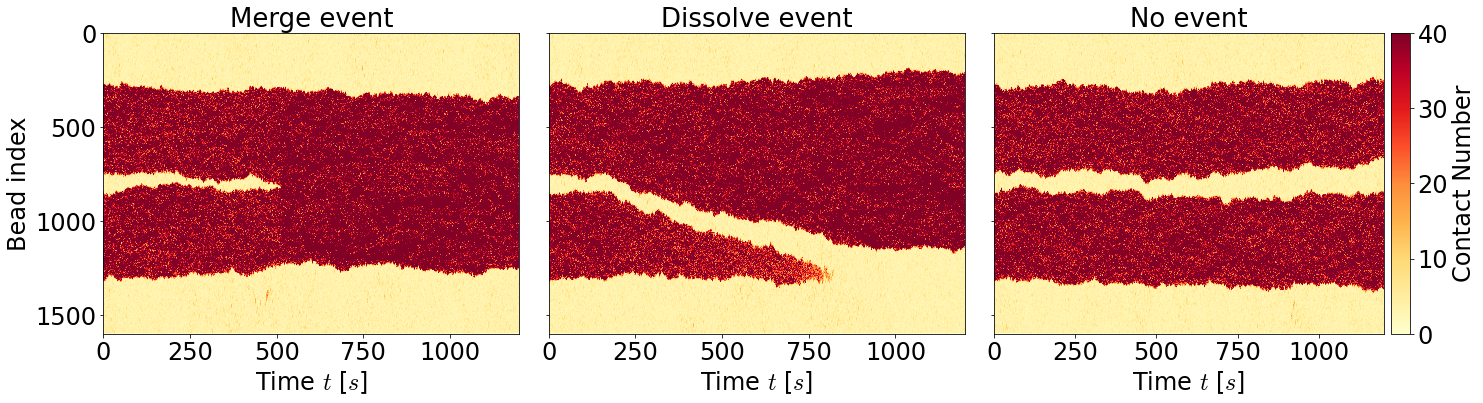

In [6]:
h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s27/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,3, figsize=(21, 6), sharex=True, sharey=True)
_ = axarr[0].set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr[0], time_arr, contact_kymo, label_flag=False, vmax=vmax)
    _ = axarr[0].set_title('Merge event', fontsize=26)

h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s12/analysis/contact_analysis.h5"
with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr[1], time_arr, contact_kymo, label_flag=False, vmax=vmax)
    _ = axarr[1].set_title('Dissolve event', fontsize=26)

h5_contact_file = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil/simulations/s25/analysis/contact_analysis.h5"

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr[2], time_arr, contact_kymo, vmax=vmax, label_flag=False)
    _ = axarr[2].set_title('No event', fontsize=26)


cax0 = make_axes_locatable(axarr[2]).append_axes("right", size="5%", pad=0.1)

cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=vmax)), 
                   cax = cax0, pad=0.1, label='Contact Number' )

_ = axarr[0].set_ylabel('Bead index')
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ [$s$]')

fig.tight_layout()

fig.savefig("Figure4/merge_dissolve_no_event_kymos.png", dpi=600,bbox_inches='tight')



In [7]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_life_times = []
dissolve_life_times = [] 
merge_time_arr = []
dissolve_time_arr = []
merge_cluster_arr = []
dissolve_cluster_arr = []
nothing_events = 0
nothing_time_arr = []
nothing_cluster_arr = []

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))
# graph_side_length = 3

# fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))

n = 0
for i in range(graph_side_length):
    for j in range(graph_side_length):
        n += 1
        if i*graph_side_length + j >= len(h5_list):
            print('break')
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            # If the two largest beginning clusters have the same root id at the end,
            # then this is a merging event

            if root0.id == root1.id:
                # Make the tree for these
                merge_tree = cla.ClusterTree(0) 
                merge_tree.add_recursive(root0)
                # Branch root with the largest mass history
                branch_root = sorted(merge_tree.get_branch_roots(), key=lambda x: x.mass_hist, reverse=True)[1]
                merge_life_times += [branch_root.time]
                print(f"{n} Merge event at time {branch_root.time}")

                l_branch = root0.get_largest_branch()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                merge_time_arr += [time_arr.copy()]
                merge_cluster_arr += [size_arr.copy()]

                sl_branch = branch_root.get_largest_branch()
                size_arr = np.zeros(len(sl_branch))
                time_arr = np.zeros(len(sl_branch))
                for k, clust in enumerate(sl_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                merge_time_arr += [time_arr.copy()]
                merge_cluster_arr += [size_arr.copy()]

                continue

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_life_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")

                l_branch = root0.get_largest_branch()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                dissolve_time_arr += [time_arr.copy()]
                dissolve_cluster_arr += [size_arr.copy()]

                l_branch = root1.get_largest_branch()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time

                dissolve_time_arr += [time_arr.copy()]
                dissolve_cluster_arr += [size_arr.copy()]
                

                continue
            
            nothing_events += 1
            print(f"{n} Nothing event")

            l_branch = root0.get_largest_branch()
            size_arr = np.zeros(len(l_branch))
            time_arr = np.zeros(len(l_branch))
            for k, clust in enumerate(l_branch):
                size_arr[k] = len(clust.part_ids)
                time_arr[k] = clust.time
            nothing_time_arr += [time_arr.copy()]
            nothing_cluster_arr += [size_arr.copy()]

            l_branch = root1.get_largest_branch()
            size_arr = np.zeros(len(l_branch))
            time_arr = np.zeros(len(l_branch))
            for k, clust in enumerate(l_branch):
                # if len(clust.part_ids) < 10:
                size_arr[k] = len(clust.part_ids)
                time_arr[k] = clust.time

            nothing_time_arr += [time_arr.copy()]
            nothing_cluster_arr += [size_arr.copy()]

        except:
            raise

48
1 Nothing event
2 Merge event at time 541.0
3 Dissolve event at time 792.0
4 Dissolve event at time 816.0
5 Nothing event
6 Nothing event
7 Nothing event
8 Nothing event
9 Nothing event
10 Nothing event
11 Nothing event
12 Dissolve event at time 800.5
13 Nothing event
14 Nothing event
15 Nothing event
16 Nothing event
17 Nothing event
18 Dissolve event at time 1145.0
19 Nothing event
20 Dissolve event at time 1090.0
21 Merge event at time 327.0
22 Nothing event
23 Nothing event
24 Dissolve event at time 1061.0
25 Merge event at time 515.0
26 Merge event at time 564.5
27 Nothing event
28 Nothing event
29 Nothing event
30 Merge event at time 1032.5
31 Nothing event
32 Nothing event
33 Dissolve event at time 1194.5
34 Nothing event
35 Nothing event
36 Nothing event
37 Nothing event
38 Nothing event
39 Nothing event
40 Dissolve event at time 1033.5
41 Merge event at time 993.0
42 Nothing event
43 Nothing event
44 Merge event at time 764.5
45 Nothing event
46 Nothing event
47 Nothing eve

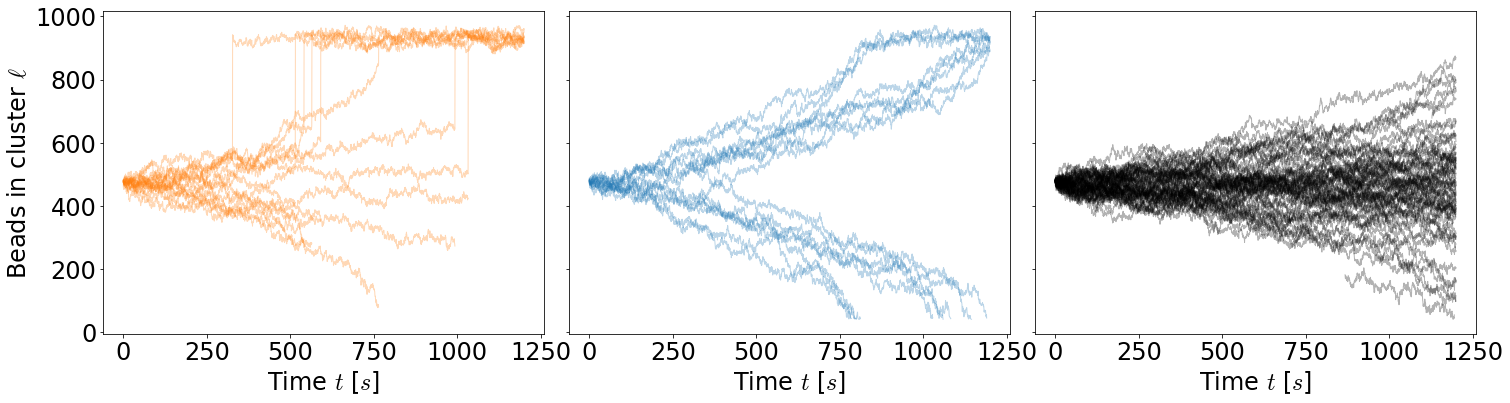

In [7]:
fig, axarr = plt.subplots(1,3, figsize=(21,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

for time_arr, clust_arr, in zip(merge_time_arr, merge_cluster_arr):
    _ = axarr[0].plot(time_arr, clust_arr, color='tab:orange', **plot_params)   

for time_arr, clust_arr, in zip(dissolve_time_arr, dissolve_cluster_arr):
    condition = clust_arr > 40 
    
    _ = axarr[1].plot(time_arr[condition], clust_arr[condition], color='tab:blue', **plot_params)

for time_arr, clust_arr, in zip(nothing_time_arr, nothing_cluster_arr):
    condition = clust_arr > 40
    
    _ = axarr[2].plot(time_arr[condition], clust_arr[condition], color='black', **plot_params)

# _ = axarr[0].set_title('Merge events')
# _ = axarr[1].set_title('Dissolve events')
# _ = axarr[2].set_title('Nothing events')

_ = axarr[0].set_ylabel('Beads in cluster $\ell$ ' )
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ [$s$]')


fig.tight_layout()
fig.savefig("Figure4/merge_dissolve_no_event_sizes.png", dpi=600,bbox_inches='tight')

In [8]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

print(len(h5_list))

large_tree_length = 240

merge_life_times = []
dissolve_life_times = [] 
merge_time_arr = []
dissolve_time_arr = []
merge_cluster_arr = []
dissolve_cluster_arr = []
nothing_events = 0
nothing_time_arr = []
nothing_cluster_arr = []

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))
# graph_side_length = 3

# fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24))

n = 0
for i in range(graph_side_length):
    for j in range(graph_side_length):
        n += 1
        if i*graph_side_length + j >= len(h5_list):
            print('break')
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                last_time = time_arr[-1]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            # The largest clusters at the start of the sim
            start_clusters = sorted(clusters[0], key=lambda x: len(x.part_ids), reverse=True)

            root0 = start_clusters[0].get_root()
            root1 = start_clusters[1].get_root()

            min_root_time = min(root0.time, root1.time)
            if min_root_time < last_time:
                dissolve_life_times += [min_root_time]
                print(f"{n} Dissolve event at time {min_root_time}")

                l_branch = root0.get_largest_branch()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time
                dissolve_time_arr += [time_arr.copy()]
                dissolve_cluster_arr += [size_arr.copy()]

                l_branch = root1.get_largest_branch()
                size_arr = np.zeros(len(l_branch))
                time_arr = np.zeros(len(l_branch))
                for k, clust in enumerate(l_branch):
                    size_arr[k] = len(clust.part_ids)
                    time_arr[k] = clust.time

                dissolve_time_arr += [time_arr.copy()]
                dissolve_cluster_arr += [size_arr.copy()]

        except:
            raise

48
3 Dissolve event at time 792.0
4 Dissolve event at time 816.0
12 Dissolve event at time 800.5
18 Dissolve event at time 1145.0
20 Dissolve event at time 1090.0
24 Dissolve event at time 1061.0
33 Dissolve event at time 1194.5
40 Dissolve event at time 1033.5
break


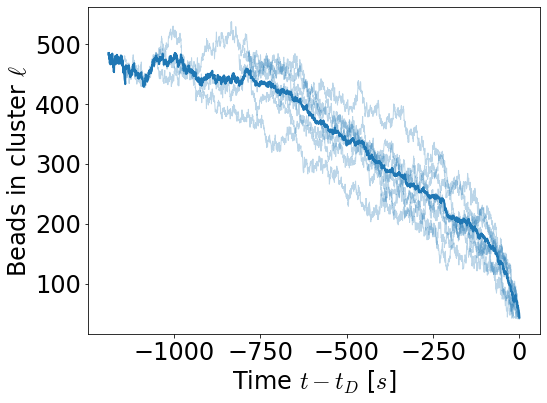

In [12]:
def mean_of_arrays(arrays):
    # Find the maximum length of the arrays
    max_length = max(arr.shape[0] for arr in arrays)

    # Create an array of np.nan values with shape (number of arrays, max length)
    padded_arrays = np.full((len(arrays), max_length), np.nan)

    # Replace the first n elements of each row with the values from the corresponding array
    for i, arr in enumerate(arrays):
        padded_arrays[i, :arr.shape[0]] = arr

    # Compute the mean along the first axis, ignoring np.nan values
    mean = np.nanmean(padded_arrays, axis=0)

    return mean

fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
for time_arr, clust_arr, in zip(dissolve_time_arr, dissolve_cluster_arr):
    condition = clust_arr > 40 
    if min(clust_arr[condition]) < 50:
        last_time_step = max(time_arr[condition])
        if len(largest_time_arr) < len(time_arr[condition]):
            largest_time_arr = time_arr[condition]
        _ = axarr.plot(time_arr[condition]-last_time_step , clust_arr[condition], color='tab:blue', **plot_params)
        cluster_size_list += [clust_arr[condition]]

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
axarr.plot(largest_time_arr-last_time_step, mean_size_arr)


_ = axarr.set_ylabel('Beads in cluster $\ell$ ' )
_ = axarr.set_xlabel('Time $t - t_D$ [$s$]')


fig.tight_layout()

<BarContainer object of 3 artists>

Text(0, 0.5, 'Number of events')

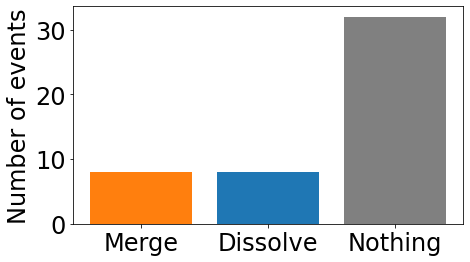

In [44]:
# Bar graph of merge events vs dissolve events vs nothing events
fig, ax = plt.subplots(1,1, figsize=(7, 4))
_ = ax.bar(['Merge', 'Dissolve', 'Nothing'], [len(merge_life_times), len(dissolve_life_times), nothing_events], color=['tab:orange', 'tab:blue', 'grey'])
_ = ax.set_ylabel('Number of events')
fig.savefig("Figure4/merge_dissolve_no_event_count.png", dpi=600,bbox_inches='tight')

Found 2 trees
Found 1 trees
Found merging tree
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 1 trees
Found merging tree
Found 2 trees
Found 2 trees
Found 2 trees
Found 1 trees
Found merging tree
Found 1 trees
Found merging tree
Found 2 trees
Found 2 trees
Found 2 trees
Found 1 trees
Found merging tree
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 2 trees
Found 3 trees
Found 1 trees
Found merging tree
Found 2 trees
Found 2 trees
Found 1 trees
Found merging tree
Found 2 trees
Found 2 trees
Found 2 trees
Found 1 trees
Found merging tree


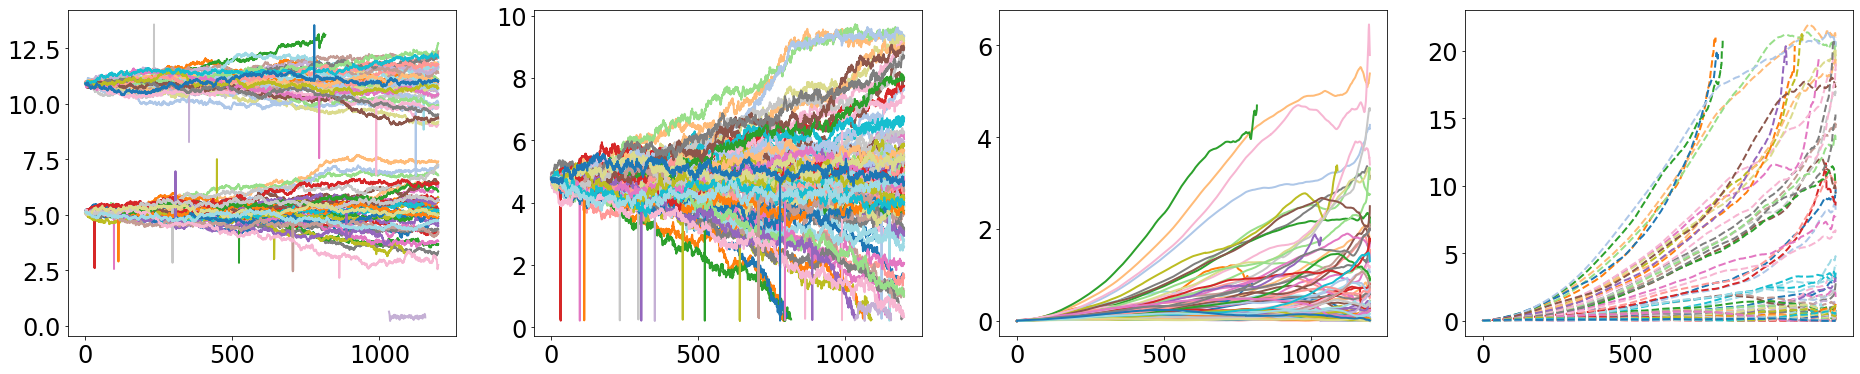

In [15]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))
large_tree_length = 100

tableau20_colors = iter(cycle(plt.cm.tab20.colors))
fig, axarr = plt.subplots(1,4, figsize=(32, 6))

com_msd_arr = []
len_msd_arr = []
for h5_cluster_file in h5_list:
    with h5py.File(h5_cluster_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]
    
    # Prune small trees
    trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

    print(f"Found {len(trees)} trees")
    if len(trees) == 1:
        print("Found merging tree")
        continue


    # Graph all clusters
    for tree, color in zip(trees, tableau20_colors):
        clust_len_arr = []
        clust_com_arr = []
        time_arr = []
        # if len(tree.clusters) < large_tree_length:
        #     continue
        for clust in tree.clusters:
            clust_len_arr += [len(clust.part_ids)]
            clust_com_arr += [np.mean(clust.part_ids)]
            time_arr += [clust.time]
        
        # Sort arrays by time
        sort_indices = np.argsort(time_arr)
        clust_len_arr = np.array(clust_len_arr, dtype=float)[sort_indices]*.01
        clust_com_arr = np.array(clust_com_arr)[sort_indices]*.01
        time_arr = np.array(time_arr)[sort_indices]

        _ = axarr[0].plot(time_arr, clust_com_arr, c=color)
        _ = axarr[1].plot(time_arr, clust_len_arr, c=color)

        com_msd = cluster_msd(clust_com_arr, device=device)
        com_msd_arr += [com_msd]
        _ = axarr[2].plot(time_arr, com_msd, c=color)

        len_msd = cluster_msd(clust_len_arr, device=device)
        len_msd_arr += [len_msd]
        _ = axarr[3].plot(time_arr, len_msd, c=color, linestyle='--')


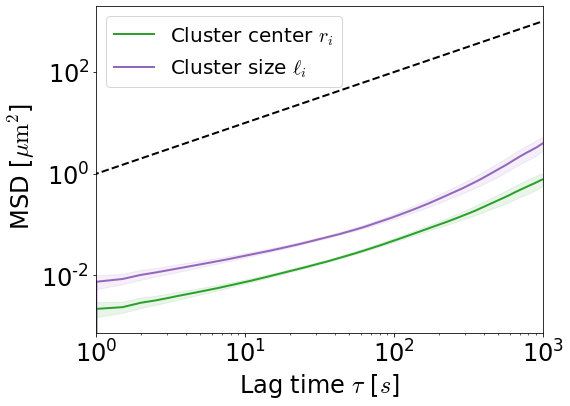

In [16]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
# twin_ax = axarr.twinx()
max_length = 2000 
avg_time_arr = time_arr[1:max_length+1]

com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
std_com_msd = np.std(com_msd_list, axis=0)
avg_com_msd = np.mean(com_msd_list, axis=0)

len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
std_len_msd = np.std(len_msd_list, axis=0)
avg_len_msd = np.mean(len_msd_list, axis=0)

plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color='C2', ci=.95, label='Cluster center $r_i$')
plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
_ = axarr.loglog(time_arr[1:max_length+1], time_arr[1:max_length+1], c='k', linestyle='--')
# _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

_ = axarr.set_ylabel(r" MSD [$\mu {\rm m}^2$]")
_ = axarr.legend()
# _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
_ = axarr.set_xlabel(r'Lag time $\tau$ [$s$]')
_ = axarr.set_xlim(1,1000)

fig.savefig("Figure4/cluster_msd.png", dpi=600,bbox_inches='tight')





Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees


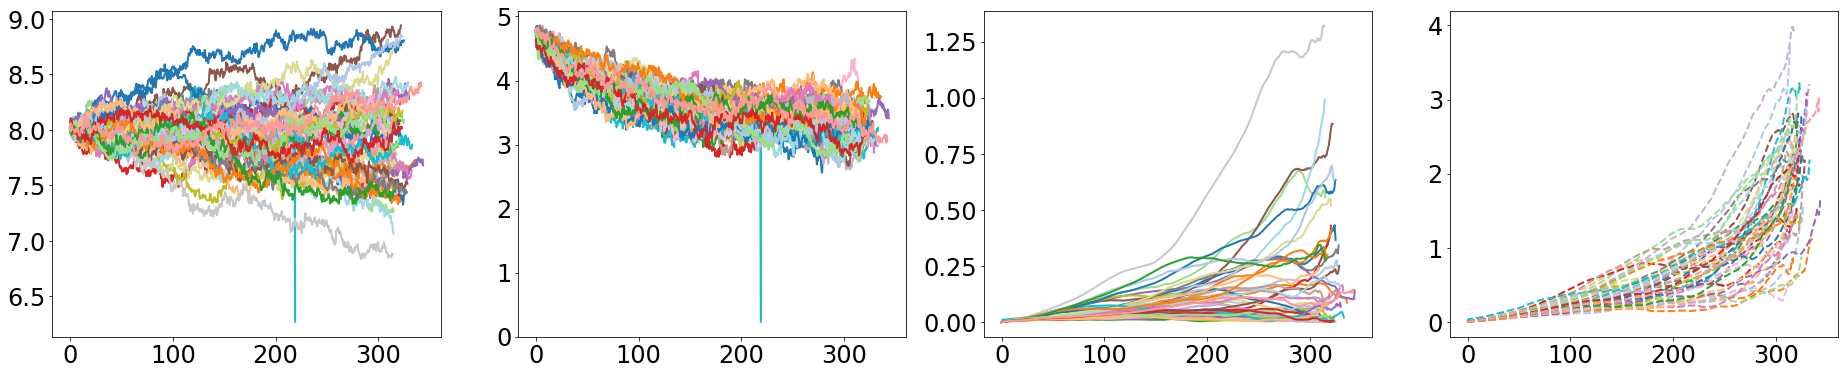

In [12]:
data_path = ceph_path / "DynCondPaper/24-05-02_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_1patch"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))
large_tree_length = 100

tableau20_colors = iter(cycle(plt.cm.tab20.colors))
fig, axarr = plt.subplots(1,4, figsize=(32, 6))

com_msd_arr = []
len_msd_arr = []
for h5_cluster_file in h5_list:
    with h5py.File(h5_cluster_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]
    
    # Prune small trees
    trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

    print(f"Found {len(trees)} trees")
    if len(trees) != 1:
        print("Found multiple trees")
        continue


    # Graph all clusters
    for tree, color in zip(trees, tableau20_colors):
        clust_len_arr = []
        clust_com_arr = []
        time_arr = []
        # if len(tree.clusters) < large_tree_length:
        #     continue
        for clust in tree.clusters:
            clust_len_arr += [len(clust.part_ids)]
            clust_com_arr += [np.mean(clust.part_ids)]
            time_arr += [clust.time]
        
        # Sort arrays by time
        sort_indices = np.argsort(time_arr)
        clust_len_arr = np.array(clust_len_arr, dtype=float)[sort_indices]*.01
        clust_com_arr = np.array(clust_com_arr)[sort_indices]*.01
        time_arr = np.array(time_arr)[sort_indices]

        _ = axarr[0].plot(time_arr, clust_com_arr, c=color)
        _ = axarr[1].plot(time_arr, clust_len_arr, c=color)

        com_msd = cluster_msd(clust_com_arr, device=device)
        com_msd_arr += [com_msd]
        _ = axarr[2].plot(time_arr, com_msd, c=color)

        len_msd = cluster_msd(clust_len_arr, device=device)
        len_msd_arr += [len_msd]
        _ = axarr[3].plot(time_arr, len_msd, c=color, linestyle='--')


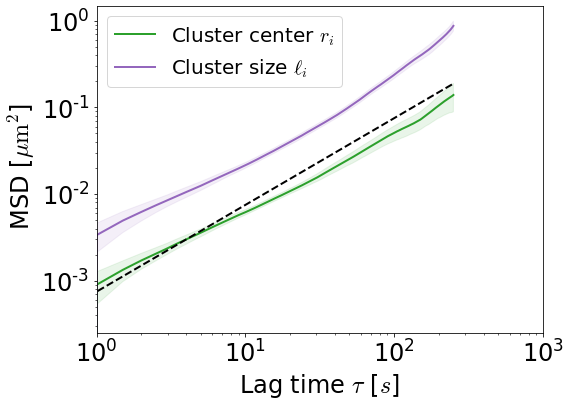

In [14]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
# twin_ax = axarr.twinx()
max_length = 500 
avg_time_arr = time_arr[1:max_length+1]

com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
std_com_msd = np.std(com_msd_list, axis=0)
avg_com_msd = np.mean(com_msd_list, axis=0)

len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
std_len_msd = np.std(len_msd_list, axis=0)
avg_len_msd = np.mean(len_msd_list, axis=0)

plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color='C2', ci=.95, label='Cluster center $r_i$')
plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
_ = axarr.loglog(time_arr[1:max_length+1], .25*30*.01*.01*time_arr[1:max_length+1], c='k', linestyle='--')
# _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

_ = axarr.set_ylabel(r" MSD [$\mu {\rm m}^2$]")
_ = axarr.legend()
# _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
_ = axarr.set_xlabel(r'Lag time $\tau$ [$s$]')
_ = axarr.set_xlim(1,1000)

fig.savefig("Figure4/cluster_msd_9um.png", dpi=600,bbox_inches='tight')





Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Found 1 trees


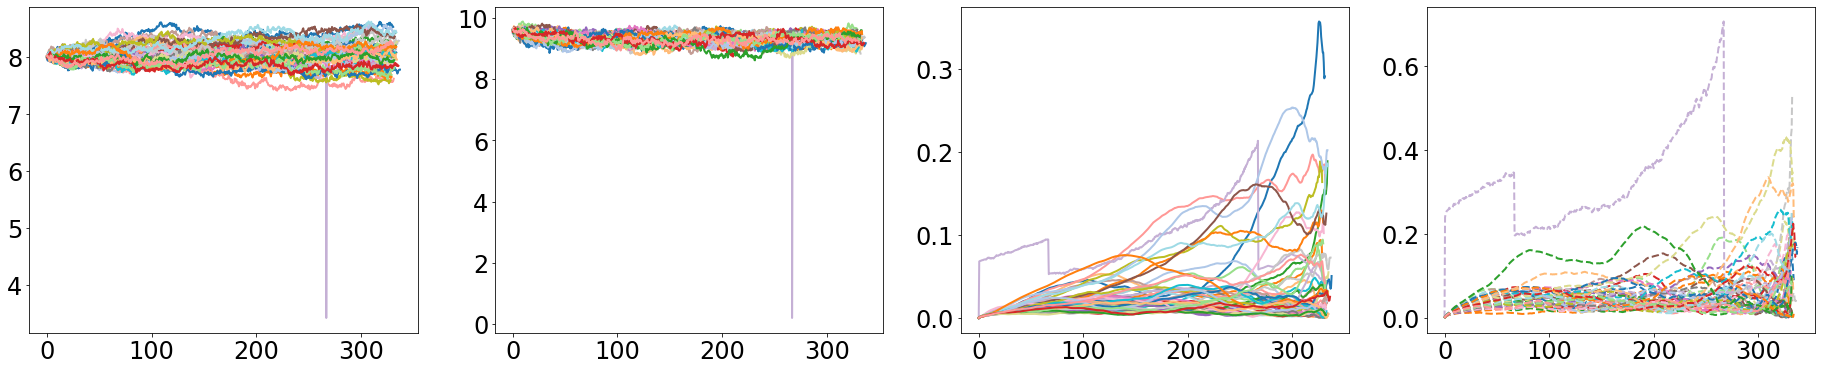

In [5]:
data_path = ceph_path / "DynCondPaper/24-05-02_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_1patch"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))
large_tree_length = 100

tableau20_colors = iter(cycle(plt.cm.tab20.colors))
fig, axarr = plt.subplots(1,4, figsize=(32, 6))

com_msd_arr = []
len_msd_arr = []
for h5_cluster_file in h5_list:
    with h5py.File(h5_cluster_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]
    
    # Prune small trees
    trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

    print(f"Found {len(trees)} trees")
    if len(trees) != 1:
        print("Found multiple trees")
        continue


    # Graph all clusters
    for tree, color in zip(trees, tableau20_colors):
        clust_len_arr = []
        clust_com_arr = []
        time_arr = []
        # if len(tree.clusters) < large_tree_length:
        #     continue
        for clust in tree.clusters:
            clust_len_arr += [len(clust.part_ids)]
            clust_com_arr += [np.mean(clust.part_ids)]
            time_arr += [clust.time]
        
        # Sort arrays by time
        sort_indices = np.argsort(time_arr)
        clust_len_arr = np.array(clust_len_arr, dtype=float)[sort_indices]*.01
        clust_com_arr = np.array(clust_com_arr)[sort_indices]*.01
        time_arr = np.array(time_arr)[sort_indices]

        _ = axarr[0].plot(time_arr, clust_com_arr, c=color)
        _ = axarr[1].plot(time_arr, clust_len_arr, c=color)

        com_msd = cluster_msd(clust_com_arr, device=device)
        com_msd_arr += [com_msd]
        _ = axarr[2].plot(time_arr, com_msd, c=color)

        len_msd = cluster_msd(clust_len_arr, device=device)
        len_msd_arr += [len_msd]
        _ = axarr[3].plot(time_arr, len_msd, c=color, linestyle='--')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


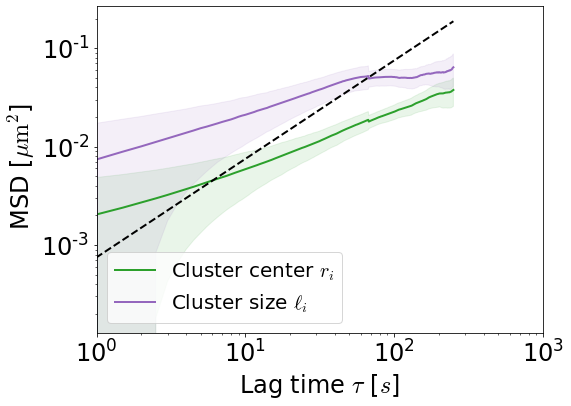

In [6]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
# twin_ax = axarr.twinx()
max_length = 500 
avg_time_arr = time_arr[1:max_length+1]

com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
std_com_msd = np.std(com_msd_list, axis=0)
avg_com_msd = np.mean(com_msd_list, axis=0)

len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
std_len_msd = np.std(len_msd_list, axis=0)
avg_len_msd = np.mean(len_msd_list, axis=0)

plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color='C2', ci=.95, label='Cluster center $r_i$')
plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
_ = axarr.loglog(time_arr[1:max_length+1], .25*30*.01*.01*time_arr[1:max_length+1], c='k', linestyle='--')
# _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

_ = axarr.set_ylabel(r" MSD [$\mu {\rm m}^2$]")
_ = axarr.legend()
# _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
_ = axarr.set_xlabel(r'Lag time $\tau$ [$s$]')
_ = axarr.set_xlim(1,1000)

fig.savefig("Figure4/cluster_msd_5um.png", dpi=600,bbox_inches='tight')





(array([0., 0., 0., 0., 0., 0., 2., 1., 0., 4., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 2.]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200.]),
 <BarContainer object of 20 artists>)

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 2., 0., 1., 2., 1., 1.,
        1., 1., 1.]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200.]),
 <BarContainer object of 20 artists>)

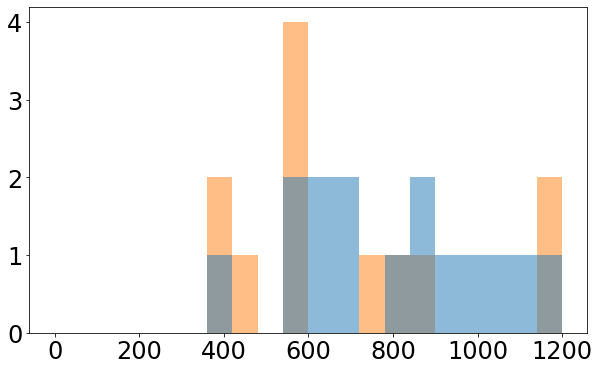

In [91]:
# Histogram of all events
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(merge_life_times, bins=20, color='tab:orange', alpha=.5, label='Merge', range=(0, 1200))
ax.hist(dissolve_life_times, bins=20, color='tab:blue', alpha=.5, label='Dissolve',range=(0, 1200))

# Supplemental figures

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


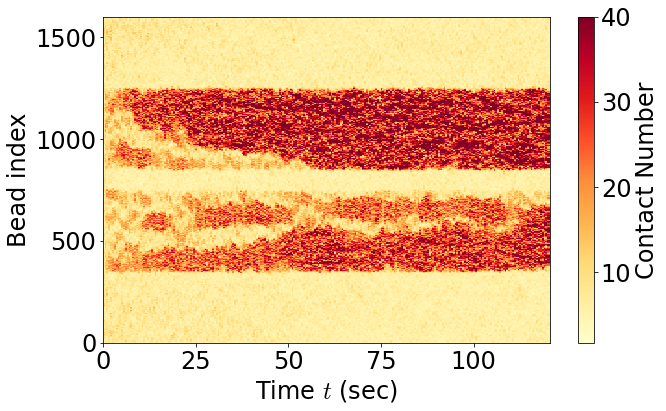

In [5]:
h5_contact_file = ceph_path / "DynCondPaper/24-03-05_aLc1_line1600_Pin5um_Ke30_ks100_2patch_100sep/analysis/contact_analysis.h5"

fig, axarr = plt.subplots(1,1, figsize=(10, 6))
_ = axarr.set_ylim(0, 1600)

with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]
    
    cgf.plot_contact_kymo(fig, axarr, time_arr, contact_kymo, vmax=vmax)



(0.0, 1600.0)

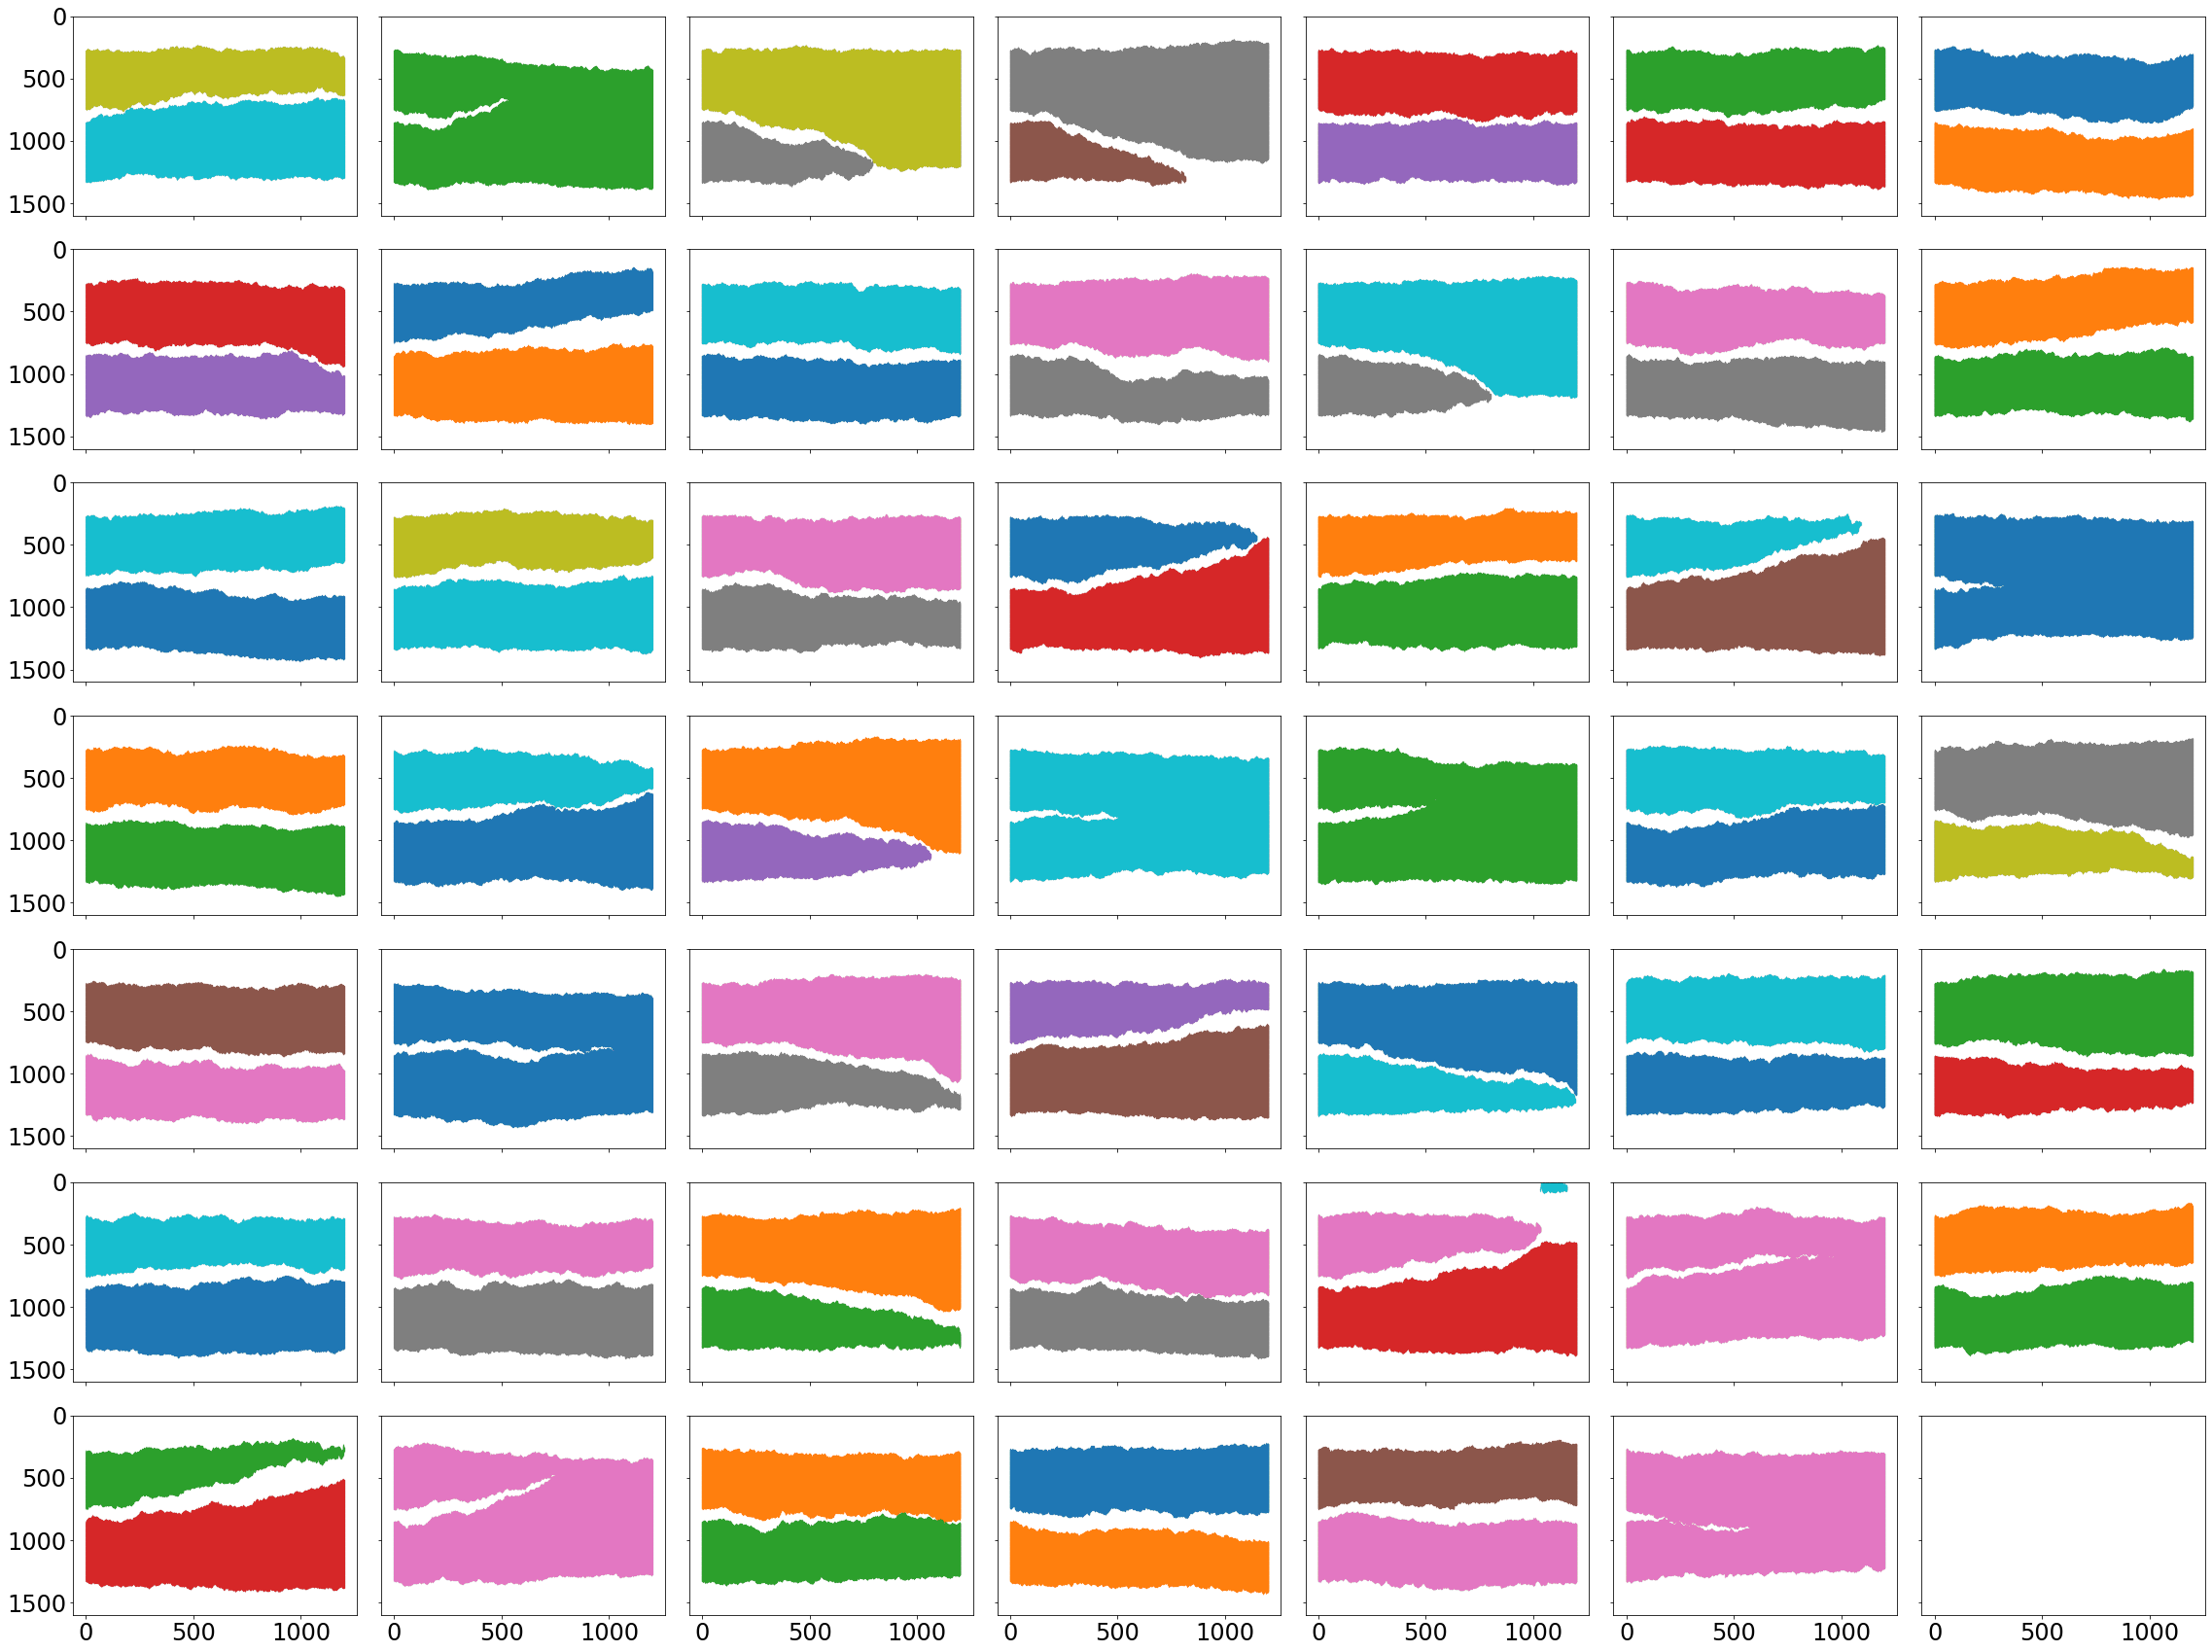

In [8]:
data_path = ceph_path / "DynCondPaper/24-04-15_aLc1_scan.48_line1600_Pin5um_2xKe30_ks100_2patch_sep100_equil"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))

large_tree_length = 100

merge_events = 0
dissovle_events = 0
nothing_events = 0

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

graph_side_length = int(np.ceil(np.sqrt(len(h5_list))))

fig, axarr = plt.subplots(graph_side_length, graph_side_length, figsize=(32, 24), sharex=True, sharey=True)

for i in range(graph_side_length):
    for j in range(graph_side_length):
        if i*graph_side_length + j >= len(h5_list):
            break
        try: 
            with h5py.File(h5_list[i*graph_side_length+j], 'r') as h5_data:
                cluster_grp = h5_data['clusters']
                time_arr = h5_data['time'][...]
                time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

            # Cluster tree
            root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

            trees = []
            tree_id_gen = aa.helpers.gen_id()
            for root in root_clusters:
                tree = cla.ClusterTree(next(tree_id_gen))
                tree.add_recursive(root)
                trees += [tree]


            # Graph all clusters
            for tree, color in zip(trees, tableau10_colors):
                if len(tree.clusters) < large_tree_length:
                    continue
                for clust in tree.clusters:
                    _ = axarr[i,j].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')
        except:
            raise

# axarr[0,0].set_xlim(0, 700)
axarr[0,0].set_ylim(0, 1600)
axarr[0,0].invert_yaxis()
fig.tight_layout()


